## Import the main libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from sklearn.model_selection import cross_val_score,cross_val_predict,RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import cohen_kappa_score,make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import PredefinedSplit
from catboost import CatBoostRegressor
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingRegressor

In [2]:
# function to return kappa score 
def kappa(estimator,X,y):
    y_predict = estimator.predict(X)
    y_predict = np.round(y_predict,decimals=0).astype(int)
    score = cohen_kappa_score(y,y_predict,weights='quadratic')
    return score

## Load the Dataset and look at the big picture 

In [3]:
#read the csv file using pandas 
train_url = '/kaggle/input/playground-series-s3e5/train.csv'
test_url = '/kaggle/input/playground-series-s3e5/test.csv'
org_data_url = '/kaggle/input/wine-quality-dataset/WineQT.csv'
df_wine = pd.read_csv(train_url, index_col = 'Id')
df_org = pd.read_csv(org_data_url, index_col = 'Id')
df_test = pd.read_csv(test_url, index_col = 'Id')
#adding org data to our dataset
df_wine = pd.concat([df_wine,df_org])
#show the head of the df
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [4]:
#showing some info about the dataset
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3199 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3199 non-null   float64
 1   volatile acidity      3199 non-null   float64
 2   citric acid           3199 non-null   float64
 3   residual sugar        3199 non-null   float64
 4   chlorides             3199 non-null   float64
 5   free sulfur dioxide   3199 non-null   float64
 6   total sulfur dioxide  3199 non-null   float64
 7   density               3199 non-null   float64
 8   pH                    3199 non-null   float64
 9   sulphates             3199 non-null   float64
 10  alcohol               3199 non-null   float64
 11  quality               3199 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 324.9 KB


In [5]:
#showing some statics about the dataset
df_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3199.000000,3199.000000,3199.000000,3199.000000,3199.00000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000
mean,8.345858,0.528936,0.266239,2.446499,0.08367,16.477024,48.049859,0.996742,3.310728,0.647168,10.424669,5.698031
std,1.720511,0.175484,0.191294,1.065161,0.03414,10.115222,32.930681,0.001863,0.147582,0.150524,1.048119,0.836977
min,4.600000,0.120000,0.000000,0.900000,0.01200,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.07100,7.000000,22.000000,0.995580,3.200000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.07900,15.000000,42.000000,0.996700,3.310000,0.620000,10.100000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.09000,23.000000,64.000000,0.997800,3.390000,0.720000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.61100,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
#checking for nulls
df_wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

* > `Dataset contains 3199 instances with no null values. All the datatypes are float64 with continuous numerical features except the target value which is int64.`

# Exploratory Data Analysis

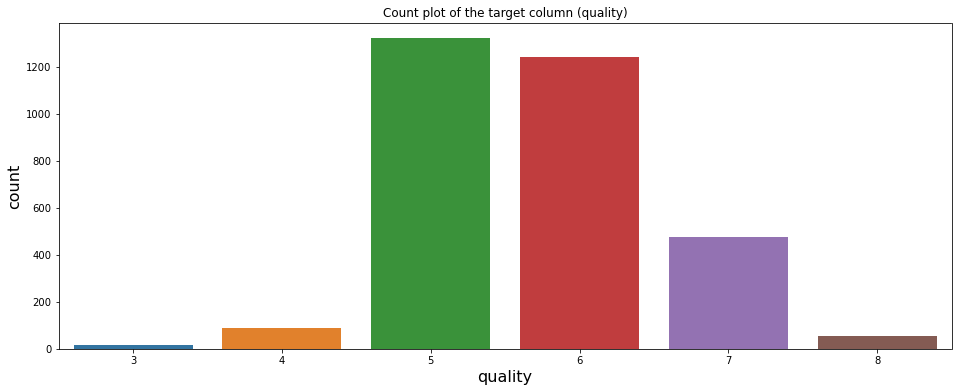

In [7]:
#Checking the distripution of the target column (quality)
plt.figure(figsize=(16,6))
sns.countplot(x=df_wine['quality'])
plt.title('Count plot of the target column (quality)')
plt.xlabel('quality',fontsize=16,c='k')
plt.ylabel('count',fontsize=16,c='k')
plt.show()

### It seems like out target value lacks some ratings (1,2,9,10) and the majority of the ratings are 5 and 6, our target column is imbalanced which is not good.

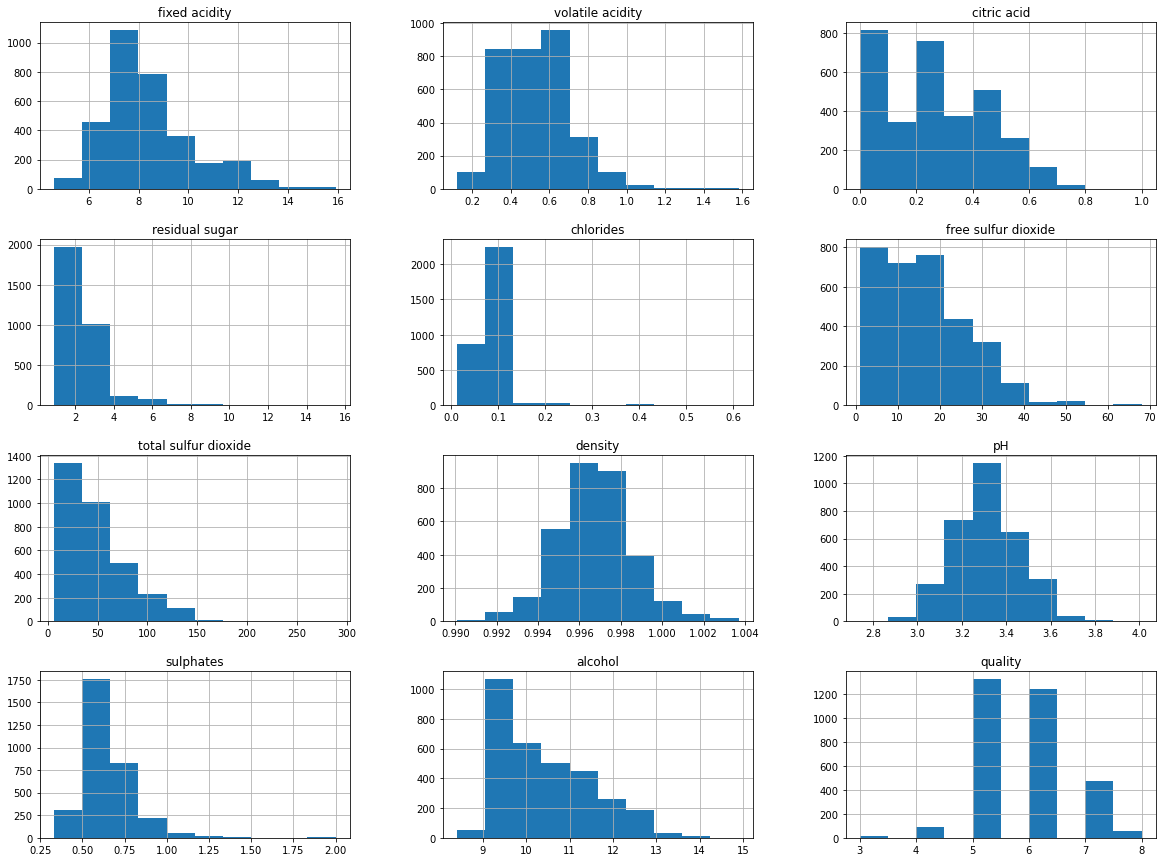

In [8]:
#histogram distripution of numerical features in the dataset
df_wine.hist(figsize=(20,15))
plt.show()

### it seems that some of the features are right skewed (exponential distribution), and it is known that the best distribution to be passed to the model is Normal Distribution, so we need to deal with this distributions.

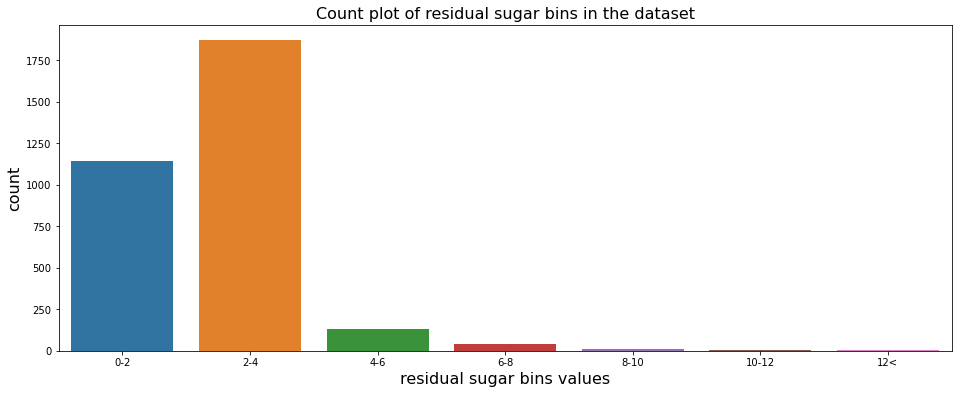

In [9]:
#cutting the numerical feature (residual sugar) into categorical one 
residual_sugar_bins = pd.cut(x=df_wine['residual sugar'],bins=[-np.inf,2,4,6,8,10,12,np.inf],
                            labels=['0-2', '2-4', '4-6', '6-8','8-10','10-12','12<'])

#count plot for the above chunks
plt.figure(figsize=(16,6))
sns.countplot(x=residual_sugar_bins)
plt.title('Count plot of residual sugar bins in the dataset',fontsize=16,c='k')
plt.xlabel('residual sugar bins values',fontsize=16,c='k')
plt.ylabel('count',fontsize=16,c='k')
plt.show()

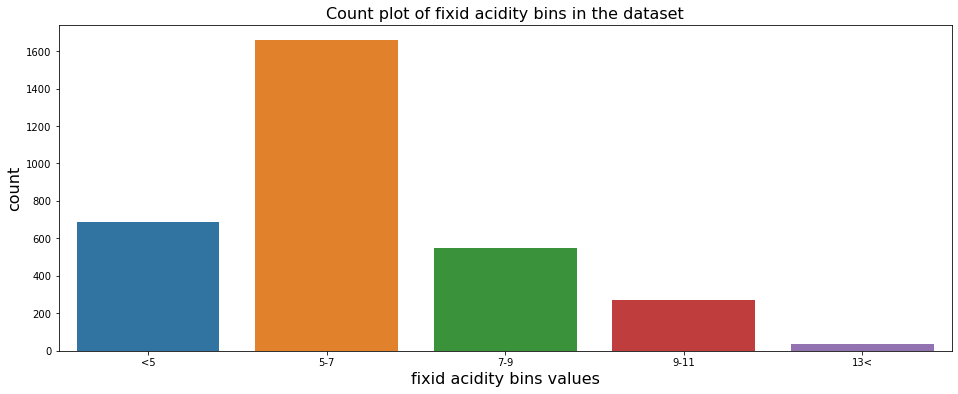

In [10]:
#lets try the same approach for fixid acidity feature
fixid_acidity_bins = pd.cut(x=df_wine['fixed acidity'],bins=[-np.inf,7,9,11,13,np.inf],
                            labels=['<5', '5-7', '7-9', '9-11','13<'])

#count plot for the above chunks
plt.figure(figsize=(16,6))
sns.countplot(x=fixid_acidity_bins)
plt.title('Count plot of fixid acidity bins in the dataset',fontsize=16,c='k')
plt.xlabel('fixid acidity bins values',fontsize=16,c='k')
plt.ylabel('count',fontsize=16,c='k')
plt.show()

> #### it seems that the majority of alcohol values are between (2-4), also the majority fixid acidity values are between (5-7)

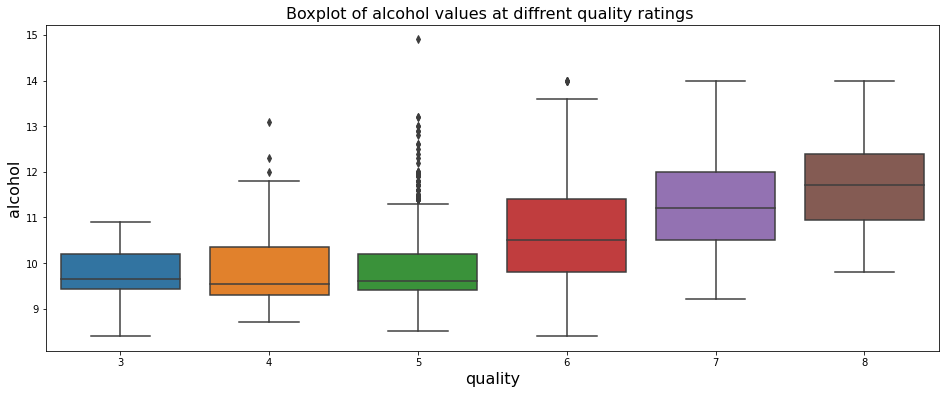

In [11]:
#Boxplot of alcohol values at diffrent quality ratings
plt.figure(figsize=(16,6))
sns.boxplot(y='alcohol',x='quality',data=df_wine)
plt.title('Boxplot of alcohol values at diffrent quality ratings ',fontsize=16,c='k')
plt.xlabel('quality',fontsize=16,c='k')
plt.ylabel('alcohol',fontsize=16,c='k')
plt.show()

> #### it seems that the more alcohol the better quality the wine be

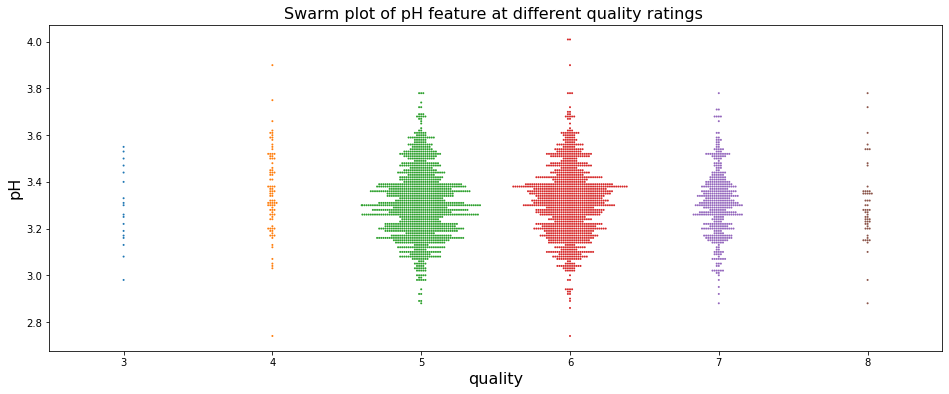

In [12]:
#swarmplot of pH values at diffrent quality ratings
plt.figure(figsize=(16,6))
sns.swarmplot(y='pH',x='quality',data=df_wine,size=2)
plt.title('Swarm plot of pH feature at different quality ratings ',fontsize=16,c='k')
plt.xlabel('quality',fontsize=16,c='k')
plt.ylabel('pH',fontsize=16,c='k')
plt.show()

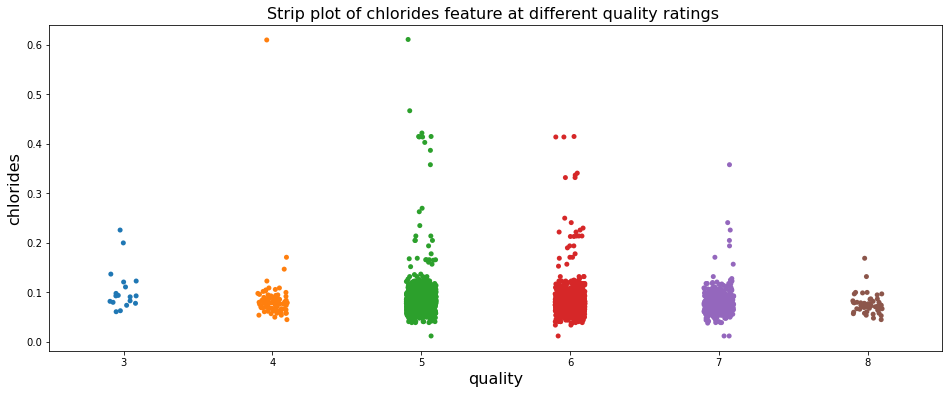

In [13]:
#Stripplot of chlorides values at diffrent quality ratings
plt.figure(figsize=(16,6))
sns.stripplot(y='chlorides',x='quality',data=df_wine)
plt.title('Strip plot of chlorides feature at different quality ratings ',fontsize=16,c='k')
plt.xlabel('quality',fontsize=16,c='k')
plt.ylabel('chlorides',fontsize=16,c='k')
plt.show()

> #### It seems that the Distributions of pH and chlorides are almost the same at different quality values

### `Checking the Correlation between the Features and Target`

In [14]:
# correlation using pearson method
df_wine.corr(method='pearson')['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.482102
sulphates               0.318649
citric acid             0.176236
fixed acidity           0.091092
residual sugar          0.032871
pH                     -0.008851
free sulfur dioxide    -0.058752
chlorides              -0.082893
density                -0.160544
total sulfur dioxide   -0.208935
volatile acidity       -0.285484
Name: quality, dtype: float64

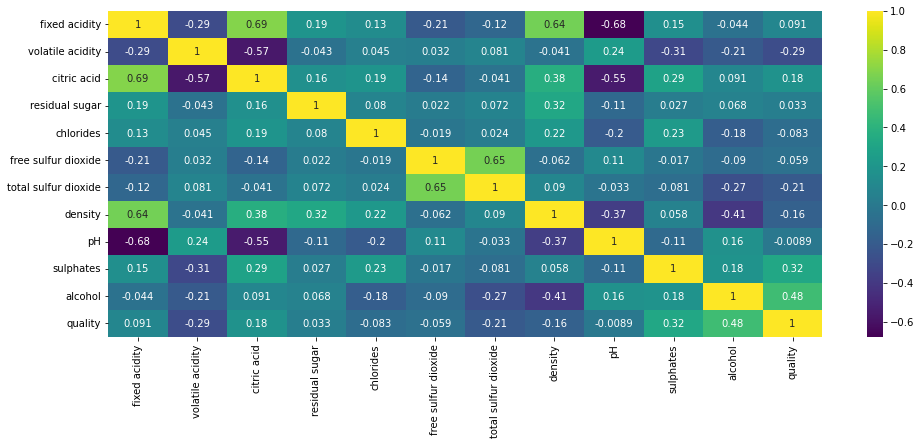

In [15]:
#showing the correlation as a heatmap
plt.figure(figsize=(16,6))
sns.heatmap(df_wine.corr(method='pearson'), annot=True, cmap='viridis')
plt.show()

> ### it seems that the most correlated feature with the target is alcohol and features like pH is the least correlated

# `Feature Engineering `

#### `Trying to add some features, thinking that it will be more useful and more correlated to the target`

In [16]:
def add_features(df):
    # Ideas from the discussions
    # some work, some don't. At your own risk...
    
    df['mso2'] = df['free sulfur dioxide']/(1+ 10**(df['pH'] -1.81))
    df['alcohol_pH'] = df['alcohol'] * df['pH']

    df['alcohol_residual_sugar'] = df['alcohol'] * df['residual sugar']

    df['pH_residual_sugar'] = df['pH'] * df['residual sugar']

    df['alcohol_citric_acid'] = df['alcohol'] * df['citric acid']

    df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
    df['acid/density'] = df['total_acid']  / df['density']
    df['alcohol_density'] = df['alcohol']  * df['density']
    df['sulphate/density'] = df['sulphates']  / df['density']
    df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
    df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
    df['sulphates/alcohol'] = df['sulphates'] / df['alcohol']
    df['acidity_ratio'] = df['fixed acidity'] / df['volatile acidity']
    df['sugar_to_chlorides'] = df['residual sugar'] / df['chlorides']
    df['alcohol_to_density'] = df['alcohol'] / df['density']
    # Create interaction features between alcohol content and volatile acidity
    df['alcohol_volatile_acidity'] = df['alcohol'] * df['volatile acidity']
    return df

In [17]:
df_wine = add_features(df_wine)
X_test = add_features(df_test)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,acid/density,alcohol_density,sulphate/density,sulphates/acid,sulphates/chlorides,sulphates/alcohol,acidity_ratio,sugar_to_chlorides,alcohol_to_density,alcohol_volatile_acidity
Id,,,,,,,,,,,,,,,,,,,,,
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,...,8.928213,12.048212,0.773310,1.540000,10.547945,0.063636,16.000000,30.136986,12.152011,6.050
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,...,10.345104,12.781312,0.670980,2.233333,7.282609,0.052344,31.000000,25.000000,12.818715,3.840
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,...,7.666065,11.261580,0.732490,1.431373,12.372881,0.064602,13.921569,35.593220,11.338551,5.763
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,...,9.214880,9.773540,0.531435,0.609195,6.309524,0.054082,9.310345,30.952381,9.826532,8.526
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,...,9.211214,9.447180,1.367604,3.777778,17.215190,0.143158,23.611111,29.113924,9.553115,3.420


In [18]:
#chlecking the correlation again
df_wine.corr(method='pearson')['quality'].sort_values(ascending=False)

quality                     1.000000
alcohol_density             0.482794
alcohol                     0.482102
alcohol_to_density          0.481269
alcohol_pH                  0.409446
sulphates/acid              0.352141
sulphate/density            0.320188
sulphates                   0.318649
sulphates/chlorides         0.293449
acidity_ratio               0.261962
alcohol_citric_acid         0.241991
citric acid                 0.176236
alcohol_residual_sugar      0.143077
sulphates/alcohol           0.108180
fixed acidity               0.091092
sugar_to_chlorides          0.090084
acid/density                0.079593
total_acid                  0.077674
residual sugar              0.032871
pH_residual_sugar           0.032392
pH                         -0.008851
free sulfur dioxide        -0.058752
mso2                       -0.070911
chlorides                  -0.082893
alcohol_volatile_acidity   -0.149923
density                    -0.160544
total sulfur dioxide       -0.208935
v

In [19]:
# # getting the features and the target 
X = df_wine.drop(axis = 1, columns='quality')
y = df_wine.pop('quality')

In [20]:
y.value_counts()

5    1322
6    1240
7     476
4      88
8      55
3      18
Name: quality, dtype: int64

In [21]:
#upsampling the data to balance the classes
sm = SMOTE()
X, y = sm.fit_resample(X, y)


In [22]:
y.value_counts()

6    1322
7    1322
5    1322
4    1322
8    1322
3    1322
Name: quality, dtype: int64

In [23]:
#splitting the data into train and validation set
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2)

## `Standardize the Features`

In [24]:
## using StandardScaler for each Feature to be (mean=0, std=1)
scaler = StandardScaler()
scaler.fit(X_train)
#scaling the train data
X_train = pd.DataFrame(columns=X.columns,data = scaler.transform(X_train),index= X_train.index)
X_valid = pd.DataFrame(columns=X.columns,data=scaler.transform(X_valid),index= X_valid.index)
X_test = pd.DataFrame(columns=X.columns,data=scaler.transform(X_test),index= X_test.index)

### `Building ML Models`



### `1. LinearRegression`

In [25]:
#First we will try simple Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [26]:
score_lin_reg = kappa(lin_reg,X_valid,y_valid)
print('Linear Regression score = ',score_lin_reg)

Linear Regression score =  0.704685746617326


In [27]:
y_lin = lin_reg.predict(X_test)
y_lin = np.round(y_lin,decimals=0).astype(int) 
df_y_lin = pd.DataFrame({'Id':X_test.index,'quality':y_lin})
df_y_lin.to_csv('y_lin.csv',index=False)
df_y_lin['quality'].value_counts()

5     473
6     363
7     217
4     214
8      80
3      14
9      10
10      1
Name: quality, dtype: int64

### `2. CatBoost`

In [28]:
cat_model= CatBoostRegressor(iterations=500, 
                          depth=4, 
                          learning_rate=0.05, 
                          loss_function='RMSE',verbose=0)
cat_model.fit(X_train,y_train)

In [29]:
score_catboost = kappa(cat_model,X_valid,y_valid)
print('Catboost Regression score = ',score_catboost)

Catboost Regression score =  0.8799696352377251


In [30]:
y_cat_test = cat_model.predict(X_test)
y_cat = np.round(y_cat_test,decimals=0).astype(int) 
df_y_cat = pd.DataFrame({'Id':X_test.index,'quality':y_cat})
df_y_cat.to_csv('y_cat.csv',index=False)
df_y_cat['quality'].value_counts()

5    548
7    331
6    321
4    143
8     27
3      2
Name: quality, dtype: int64

### `Catboost Tuning`

In [31]:
cat_parameters = {'iterations':np.arange(100,1000,100), 
                          'depth':np.arange(1,5,1), 
                          'learning_rate':[0.05,0.08]}

search_catboost = GridSearchCV(estimator=cat_model, param_grid=cat_parameters, 
                                         verbose=1,cv=5)

search_catboost.fit(X_train,y_train, eval_set=[(X_valid, y_valid)])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f1f90b08250>,
             param_grid={'depth': array([1, 2, 3, 4]),
                         'iterations': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                         'learning_rate': [0.05, 0.08]},
             verbose=1)

In [32]:
## Get the best Params
best_cat_params = search_catboost.best_params_
print('best_cat_params -- ', best_cat_params)

## Get the best estimator
best_cat = search_catboost.best_estimator_  ## predict using this Model
print('best_cat -- ', best_cat)

best_cat_params --  {'depth': 4, 'iterations': 900, 'learning_rate': 0.08}
best_cat --  <catboost.core.CatBoostRegressor object at 0x7f1f92b92f90>


In [33]:
score_Best_catboost = kappa(best_cat,X_valid,y_valid)
print('Best Catboost Regression score = ',score_Best_catboost)

Best Catboost Regression score =  0.913741412755483


### `3. RandomForest`

In [34]:
# trying random forest regressor
forest_reg = RandomForestRegressor(n_estimators=100,max_samples=0.8,
                                   max_depth=6, n_jobs=-1,
                                  min_samples_split=4,max_features=0.8)
forest_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, max_features=0.8, max_samples=0.8,
                      min_samples_split=4, n_jobs=-1)

In [35]:
score_RF = kappa(forest_reg,X_valid,y_valid)
print('Random Forest score = ',score_RF)

Random Forest score =  0.8132691480037181


### `RF Tuning`

In [36]:
## Using GridSearchCV

param_forest = {'n_estimators': [200,300,400], 
                     'max_depth':np.arange(2,5,1), 
                     'max_samples':[0.7,0.8],
                     'min_samples_split':np.arange(2,7,2),
                'max_features':[0.8,"sqrt","log2"]
               }


## Intialize
search_random_forest = GridSearchCV(estimator=forest_reg, param_grid=param_forest, 
                                         verbose=1,cv=5)

# Fit with all data
search_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=6, max_features=0.8,
                                             max_samples=0.8,
                                             min_samples_split=4, n_jobs=-1),
             param_grid={'max_depth': array([2, 3, 4]),
                         'max_features': [0.8, 'sqrt', 'log2'],
                         'max_samples': [0.7, 0.8],
                         'min_samples_split': array([2, 4, 6]),
                         'n_estimators': [200, 300, 400]},
             verbose=1)

In [37]:
## Get the best Params
best_forest_params = search_random_forest.best_params_
print('best_forest_params -- ', best_forest_params)

## Get the best estimator
best_forest = search_random_forest.best_estimator_  ## predict using this Model
print('best_forest -- ', best_forest)

best_forest_params --  {'max_depth': 4, 'max_features': 0.8, 'max_samples': 0.7, 'min_samples_split': 6, 'n_estimators': 400}
best_forest --  RandomForestRegressor(max_depth=4, max_features=0.8, max_samples=0.7,
                      min_samples_split=6, n_estimators=400, n_jobs=-1)


In [38]:
score_best_RF = kappa(best_forest,X_valid,y_valid)
print('Best Random Forest score = ',score_best_RF)

Best Random Forest score =  0.7557659341525458


### `Feature Importance using RF`

In [39]:
## Getting the Features Importance (they are normalized in RF, sum=1)
feat_import_forest = {}   ## to append in it
for name, score in zip(X_train.columns, best_forest.feature_importances_[:]):  ## take only the first 11 Numerical Cols
    feat_import_forest[name] = score
    
## Features are keys, Importance is the value
keys_forest = feat_import_forest.keys()
values_forest = feat_import_forest.values()

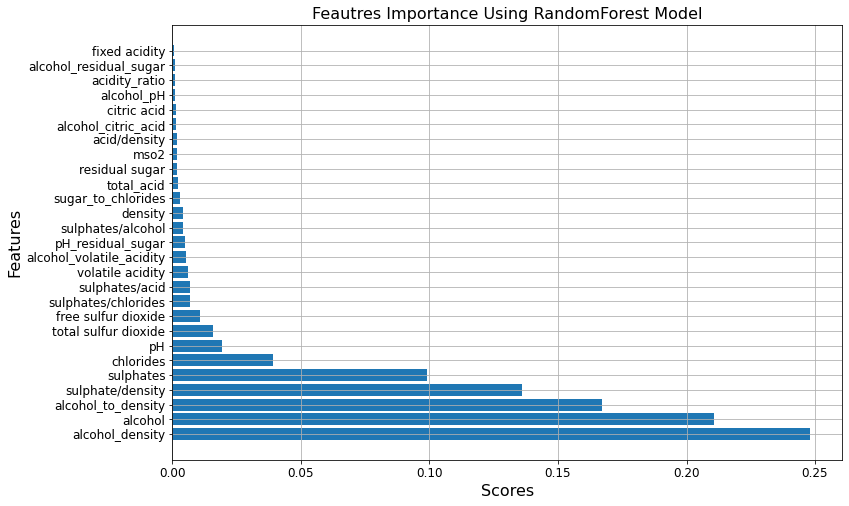

In [40]:
## to DF and then plotting
df_feat_import_forest = pd.DataFrame({'Features': keys_forest, 'Scores': values_forest})
df_feat_import_forest = df_feat_import_forest.sort_values(by='Scores', ascending=False)

## plotting
plt.figure(figsize=(12, 8))
plt.barh(y=df_feat_import_forest['Features'], width=df_feat_import_forest['Scores'])
plt.title('Feautres Importance Using RandomForest Model', fontsize=16, c='k')
plt.xlabel('Scores', fontsize=16, c='k')
plt.ylabel('Features', fontsize=16, c='k')
plt.xticks(c='k', fontsize=12)
plt.yticks(c='k', fontsize=12)
plt.grid('on')
plt.show()

### `5. XGboost`

In [41]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, subsample=0.8
                       ,eta=0.2,gamma=0.1,min_child_weight=2
                       ,max_delta_step=2,scale_pos_weight=2)
xgb_reg.fit(X_train, y_train,
         
           )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=2, max_depth=3, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [42]:
score_xgb_reg = kappa(xgb_reg,X_valid,y_valid)
print('XGB Regressor score = ',score_xgb_reg)

XGB Regressor score =  0.7847367285814384


### `Tuning XGBoost`

In [43]:
### Let's try tuning XGBoost using GridSearchCV  
params_best_xgb = {'n_estimators':np.arange(200,500,100), 'max_depth':np.arange(2,5,1), 
                    'subsample':[0.7,0.8],
                  'min_child_weight':np.arange(2,4,1),'max_delta_step':np.arange(1,4,1)}


## Intitalize the GridSearchCV and Fit the Data
grid_xgb = GridSearchCV(estimator=xgb_reg, param_grid=params_best_xgb, cv=5, 
                        n_jobs=-1)
grid_xgb.fit(X_train, y_train)  ## train

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.2,
                                    eval_metric=None, gamma=0.1, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.05, max_bin=256,
                                    max_...,
                                    max_depth=3, max_leaves=0,
                                    min_child_weight=2, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_job

In [44]:
## Get the best Params
best_xgb_params = grid_xgb.best_params_
print('best_xgb_params -- ', best_xgb_params)

## Get the best estimator
best_xgb = grid_xgb.best_estimator_  ## predict using this Model
print('best_xgb -- ', best_xgb)

best_xgb_params --  {'max_delta_step': 3, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7}
best_xgb --  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=3, max_depth=4, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)


In [45]:
score_best_xgb_regressor = kappa(best_xgb,X_valid,y_valid)
print('Best XGB Regressor score = ',score_best_xgb_regressor)

Best XGB Regressor score =  0.905871704220836


## Creating submission file 

In [46]:
y_cat = best_cat.predict(X_test)
y_rf = best_forest.predict(X_test)
y_xgb = best_xgb.predict(X_test)

# taking the mean of all 3 models to raise the accuracy 

y_mean = (y_cat+y_rf+y_xgb)/3
# rounding the values
y_mean = np.round(y_mean,decimals=0).astype(int) 
df_y_mean = pd.DataFrame({'Id':X_test.index,'quality':y_mean})
df_y_mean.to_csv('submission.csv',index=False)
df_y_mean['quality'].value_counts()


5    599
7    346
6    315
4    105
8      7
Name: quality, dtype: int64